### Implementing Sentiment Analysis for the Machine Hack Hackathon using the Tf-IDF model

#### Importing the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
twitter_df = pd.read_csv("train.csv")

In [3]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44100 entries, 0 to 44099
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         44100 non-null  int64 
 1   author     44100 non-null  object
 2   Review     44100 non-null  object
 3   Sentiment  44100 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.3+ MB


In [4]:
twitter_df.head(10)

,ID,author,Review,Sentiment
0,39467,rayinstirling,Today I'm working on my &quot;Quirky Q&quot; c...,2
1,30154,DirtyRose17,@ShannonElizab dont ya know? people love the h...,1
2,16767,yoliemichelle,ughhh rejected from the 09 mediation program. ...,0
3,9334,jayamelwani,@petewentz im so jealous. i want an octo drive,0
4,61178,aliisanoun,I remember all the hype around this movie when...,0
5,54688,empressjazzy1,I liked this quite a bit but I have friends th...,2
6,34838,lorrief,loving that spring definitely seems to be here...,2
7,28520,GE0RGIE,@jeg007jeg yay coutch:couch,2
8,31974,BrandonCarlson,"Working on the store's Facebook group, getting...",2
9,14323,allshookup,@falselove OH THAT'S GOOD! My top 4 are: The H...,0


It can be seen that:
> - Some reviews have the user's info seen as: @username
> - There are words which do not necessarily contribute to the sentiment expressed, also known as stopwords.
> - Additionally there are also HTML tags present.<br> 

#### Hence, proceeding to the next section, which is to clean the data.

!pip install wordcloud

In [5]:
from wordcloud import WordCloud

#### Starting with the text cleaning and following these steps:
1) Removing twitter handle<br>
2) Removing HTML tags<br>
3) Removing URLs<br>
4) Removing punctuations<br>
5) Removing stopwords<br>
6) Performing lemmatization<br>
> a) Using Spacy lemmatizer<br>
 

#### Step 1: Convert data to lower-case

In [6]:
twitter_df["Review"] = twitter_df["Review"].str.lower()

#### Performing steps 2-6 in a function

In [7]:
import string
import re

In [8]:
import spacy

In [9]:
import en_core_web_sm
from spacy.lang.en.stop_words import STOP_WORDS

nlp = en_core_web_sm.load()

In [10]:
punctuations = string.punctuation

In [11]:
def clean_data(review):
    remove_username = re.sub('@\S+','',review)
    remove_html_tags = re.sub('<[\w/]+>','',remove_username)
    remove_urls = re.sub(r'https?://\S+','',remove_html_tags)
    remove_punctuations = remove_urls.translate(str.maketrans('','',punctuations))
    doc = nlp(remove_punctuations)
    remove_stopwords_and_lemmatize = " ".join([token.lemma_ for token in doc if token.is_stop == False])
    return remove_stopwords_and_lemmatize

In [12]:
twitter_df["Review"] = twitter_df["Review"].apply(lambda review:clean_data(review))

In [13]:
twitter_df["Review"] 

0        today be work quotquirky qquot cue maybe concerto
1                    not ya know people love human society
2               ughhh reject 09 mediation program suckssss
3                               be jealous want octo drive
4        remember hype movie aaliyah kill fan ms rice n...
                               ...                        
44095    mother weird lowbudget movie touch uncomfortab...
44096    start weird middle weird ending weird like mod...
44097    amazed quick arrival original lg cell phone ba...
44098    attractive marjoriefarrah fawcettlive fear acc...
44099      get quotyour video start 15 secondsquot exit...
Name: Review, Length: 44100, dtype: object

#### Using word-cloud to visualize the most frequently occurring words of each target class

In [14]:
def get_token(target):
    tokens = ''
    for token in twitter_df[twitter_df["Sentiment"]==target]['Review'].str.split():
        tokens+=" ".join(token)
    return tokens

In [15]:
negative_reviews_tokens = get_token(0)
neutral_reviews_tokens = get_token(1)
positive_reviews_tokens = get_token(2)

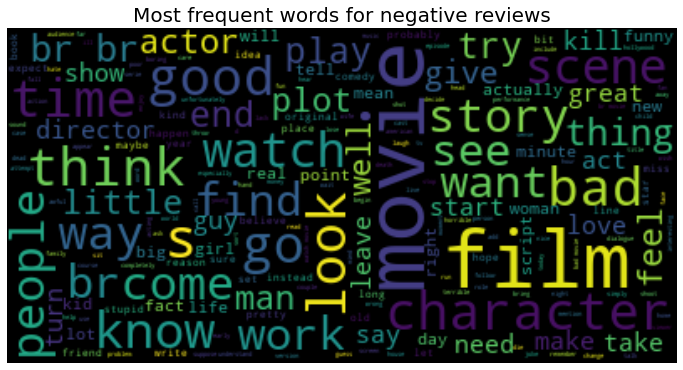

In [16]:
plt.figure(figsize=(12,10))
word_cloud = WordCloud(background_color='black',max_font_size=50).generate(negative_reviews_tokens)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words for negative reviews', fontsize=20)
plt.show()

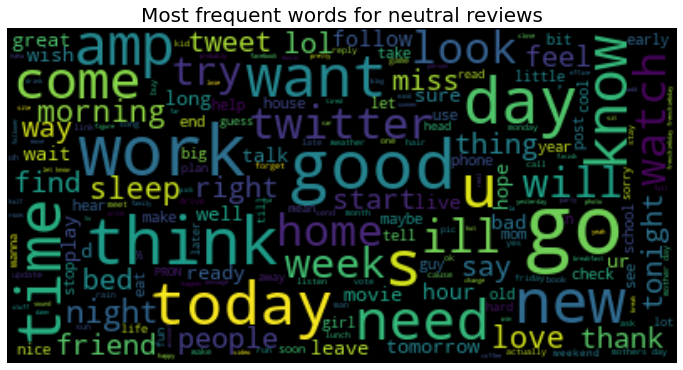

In [17]:
plt.figure(figsize=(12,10))
word_cloud = WordCloud(background_color='black',max_font_size=50).generate(neutral_reviews_tokens)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words for neutral reviews', fontsize=20)
plt.show()

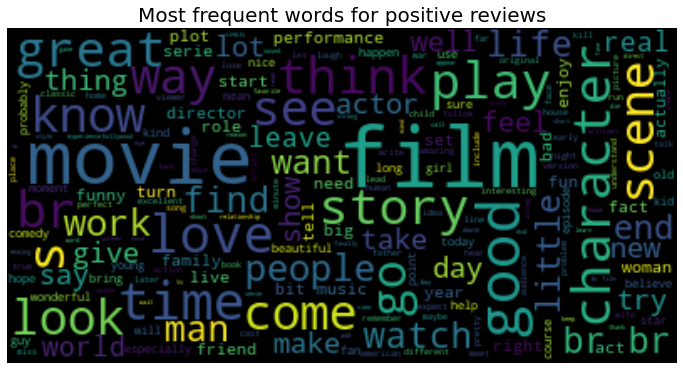

In [18]:
plt.figure(figsize=(12,10))
word_cloud = WordCloud(background_color='black',max_font_size=50).generate(positive_reviews_tokens)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words for positive reviews', fontsize=20)
plt.show()

In [19]:
review_series = twitter_df["Review"]

#### Performing word-embeddings with TfIDF

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [21]:
tfidf_vectorizer = TfidfVectorizer(max_df = 0.7)

In [22]:
X = tfidf_vectorizer.fit_transform(review_series)

In [23]:
type(X)

scipy.sparse.csr.csr_matrix

In [24]:
Y = twitter_df['Sentiment']

In [25]:
Y

0        2
1        1
2        0
3        0
4        0
        ..
44095    2
44096    2
44097    2
44098    2
44099    0
Name: Sentiment, Length: 44100, dtype: int64

#### Splitting the dataset into training and test set

In [26]:
from sklearn.model_selection import train_test_split as tts

In [27]:
X_train,X_test,Y_train,Y_test = tts(X,Y,test_size = 0.30,random_state = 0)

#### Building the different models:
1) Logistic Regression -> Base Model<br>
2) Random Forest Classifier<br>
3) XGBoost Classifier<br>

In [28]:
from sklearn.linear_model import LogisticRegression

In [29]:
logit_classifier = LogisticRegression(random_state = 0)

In [30]:
logit_classifier.fit(X_train,Y_train)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(random_state=0)

In [31]:
Y_pred = logit_classifier.predict(X_test)

In [32]:
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score

In [33]:
print(confusion_matrix(Y_test,Y_pred))

[[4435  152 1112]
 [ 870  248  738]
 [1199  189 4287]]


In [34]:
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.68      0.78      0.73      5699
           1       0.42      0.13      0.20      1856
           2       0.70      0.76      0.73      5675

    accuracy                           0.68     13230
   macro avg       0.60      0.56      0.55     13230
weighted avg       0.65      0.68      0.65     13230



In [35]:
Y_pred_roc = logit_classifier.predict_proba(X_test)

In [36]:
print(roc_auc_score(Y_test,Y_pred_roc,multi_class='ovo'))

0.8079152164220984


#### Performing hyperparameter tuning for logistic regression classifier.<br>
 - Although there aren't any specific hyperparameters, there are few parameters to tune:<br>
     (1) Solver<br>
     (2) C values
 - Here, Grid Search CV will be performed to execute the tuning.


#### Performing repeated k-fold cross-validation on the data

In [37]:
from sklearn.model_selection import StratifiedKFold

In [38]:
from sklearn.model_selection import GridSearchCV

In [39]:
cv = StratifiedKFold(n_splits = 5,random_state = 0, shuffle = True)

In [40]:
solvers = ['newton-cg', 'lbfgs', 'liblinear']

In [41]:
c_values = [100,10,1,0.1,0.01]

In [42]:
grid_params = dict(solver = solvers,C = c_values)

In [43]:
grid_cv = GridSearchCV(estimator = logit_classifier,param_grid = grid_params,scoring='accuracy',cv=cv,n_jobs=-1)

In [44]:
result_grid_cv = grid_cv.fit(X_train,Y_train)

In [45]:
print(f"Best score and optimal hyperparameter values are: {result_grid_cv.best_score_,result_grid_cv.best_params_}")

Best score and optimal hyperparameter values are: (0.6733398121153222, {'C': 1, 'solver': 'liblinear'})


#### It can be seen that even with tuning, the model is performing poorly. Proceeding to the bagging and boosting algorithms to build better models and check on the performance.

In [46]:
from sklearn.ensemble import RandomForestClassifier

In [47]:
rf_classifier = RandomForestClassifier(n_estimators = 100,criterion = 'entropy',random_state = 0)

In [48]:
rf_classifier.fit(X_train,Y_train)

RandomForestClassifier(criterion='entropy', random_state=0)

In [49]:
Y_pred_rf = rf_classifier.predict(X_test)

In [50]:
Y_pred_roc_rf = rf_classifier.predict_proba(X_test)

In [51]:
print(f"Random Forest model\nConfusion Matrix:\n {confusion_matrix(Y_test,Y_pred_rf)}")

Random Forest model
Confusion Matrix:
 [[4260  380 1059]
 [ 769  477  610]
 [1310  375 3990]]


In [52]:
print(f"Random Forest model\nClassification Report:\n{classification_report(Y_test,Y_pred_rf)}")

Random Forest model
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.75      0.71      5699
           1       0.39      0.26      0.31      1856
           2       0.71      0.70      0.70      5675

    accuracy                           0.66     13230
   macro avg       0.59      0.57      0.57     13230
weighted avg       0.65      0.66      0.65     13230



In [53]:
print(f"AUC-ROC score: {roc_auc_score(Y_test,Y_pred_roc_rf,multi_class='ovo')}")

AUC-ROC score: 0.7806088859710889


#### It can be seen that the random forest model is performing as poorly as the logistic regression model. Performing tuning.

In [54]:
cv = StratifiedKFold(n_splits = 5,random_state = 0, shuffle = True)

In [55]:
n_estimators = [10,50,100,200,300]
criterion = ['gini','entropy']
max_depth = [1,3,7,10]
max_leaf_nodes = [1,3,5,7]

In [56]:
grid_params_rf = dict(n_estimators = n_estimators,criterion = criterion,max_depth = max_depth,max_leaf_nodes = max_leaf_nodes)

In [57]:
grid_cv_rf = GridSearchCV(estimator = rf_classifier,param_grid = grid_params_rf,scoring='accuracy',cv=cv,n_jobs=-1)

In [58]:
result_grid_cv = grid_cv_rf.fit(X_train,Y_train)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan 0.45704568
 0.45617104 0.44619372 0.44399093 0.44473599 0.45704568 0.45617104
 0.44619372 0.44399093 0.44473599 0.45704568 0.45617104 0.44619372
 0.44399093 0.44473599        nan        nan        nan        nan
        nan 0.46099773 0.47599611 0.46566246 0.46673145 0.46342728
 0.4734046  0.49854227 0.49222546 0.49011986 0.48739877 0.47376093
 0.50093942 0.49397473 0.49216067 0.48888889        nan        nan
        nan        nan        nan 0.46099773 0.47599611 0.46566246
 0.46673145 0.46342728 0.47771299 0.51399417 0.51282799 0.50897311
 0.50599287 0.49536767 0.54045999 0.54619372 0.54505993 0.54444444
        nan        nan        nan        nan        nan 0.46099773
 0.47599611 0.46566246 0.46673145 0.46342728 0.47771299 0.51399417
 0.51282799 0.50897311 0.50599287 0.49536767 0.54045999 

In [59]:
print(f"Best score: {result_grid_cv.best_score_}\nBest parameter combinations {result_grid_cv.best_params_}")

Best score: 0.5461937155814708
Best parameter combinations {'criterion': 'gini', 'max_depth': 7, 'max_leaf_nodes': 7, 'n_estimators': 100}


#### It can be seen that the random forest model is performing inferior to the Logistic Regression model. Proceeding to build the XGBoost model.

In [60]:
from xgboost import XGBClassifier

In [61]:
xgb_classifier = XGBClassifier(n_estimators = 100,max_depth = 6).fit(X_train,Y_train)

In [62]:
Y_pred_xgb = xgb_classifier.predict(X_test)

In [63]:
Y_pred_roc_xgb = xgb_classifier.predict_proba(X_test)

In [64]:
print(f"Confusion matrix:\n{confusion_matrix(Y_test,Y_pred_xgb)}")

Confusion matrix:
[[4604   85 1010]
 [1200  126  530]
 [1667   93 3915]]


In [65]:
print(f"Classification report:\n{classification_report(Y_test,Y_pred_xgb)}")

Classification report:
              precision    recall  f1-score   support

           0       0.62      0.81      0.70      5699
           1       0.41      0.07      0.12      1856
           2       0.72      0.69      0.70      5675

    accuracy                           0.65     13230
   macro avg       0.58      0.52      0.51     13230
weighted avg       0.63      0.65      0.62     13230



In [66]:
print(f"AUC-ROC score: {roc_auc_score(Y_test,Y_pred_roc_xgb,multi_class='ovo')}")

AUC-ROC score: 0.8048289793710505


#### Out of the three models, XGBoost has shown to be more effective than both Logistic Regression and Random Forest. Performing hyper-parameter tuning.

In [67]:
cv = StratifiedKFold(n_splits = 3,random_state = 0,shuffle = True)

In [68]:
max_depth = [4,6,8,10]
n_estimators = [20,100,150,200]

In [69]:
grid_search_params = dict(max_depth=max_depth,n_estimators=n_estimators)

In [70]:
grid_search_cv = GridSearchCV(estimator=xgb_classifier,param_grid=grid_search_params,scoring='accuracy',cv=cv,n_jobs=-1)

In [71]:
result_grid_xgb = grid_search_cv.fit(X_train,Y_train)

In [72]:
print(f"Best score: {result_grid_xgb.best_score_}\nBest parameter combinations {result_grid_xgb.best_params_}")

Best score: 0.657207644962747
Best parameter combinations {'max_depth': 4, 'n_estimators': 200}


#### Since both the models are performing poorly, it is important to look into the preprocessing once again. Instead of using the spacy lemmatizer, a different word-embedding strategy is adopted. Here, Tensorflow's tokenizer is used and additional other variants are deployed.

In [73]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM,Dense,Conv1D,MaxPooling1D,Dropout

In [74]:
tf.version

<module 'tensorflow._api.v2.version' from 'C:\\Users\\HP\\anaconda3\\lib\\site-packages\\tensorflow\\_api\\v2\\version\\__init__.py'>

In [75]:
X_tf = twitter_df['Review']
Y_tf = twitter_df['Sentiment']

In [76]:
X_train,X_test,Y_train,Y_test = tts(X_tf,Y_tf,test_size = 0.30,random_state = 0)

In [77]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [78]:
token = Tokenizer(num_words=10000,lower=True,split=' ')

In [79]:
token.fit_on_texts(X_train)

In [80]:
X_train_seq = token.texts_to_sequences(X_train)
X_test_seq = token.texts_to_sequences(X_test)

In [81]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [82]:
X_train_seq_trunc = pad_sequences(X_train_seq, maxlen = 20)
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen = 20)

In [90]:
Y_train = to_categorical(Y_train, 3)
Y_test = to_categorical(Y_test,3)

#### Building the keras model

In [83]:
from tensorflow.keras import models
from tensorflow.keras import layers

In [88]:
from tensorflow.keras.utils import to_categorical

In [97]:
model = models.Sequential()

In [98]:
model.add(Embedding(10000, 64, input_length = 20))
model.add(Conv1D(filters=16,kernel_size=3,activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32,kernel_size=3,activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(64,dropout = 0.5))
model.add(Dense(3, activation='softmax'))

In [99]:
model.compile(optimizer = tf.keras.optimizers.Adam(lr=1e-3),loss='categorical_crossentropy',metrics=['acc']) 

In [100]:
history = model.fit(X_train_seq_trunc,Y_train,epochs = 25,validation_data=(X_test_seq_trunc,Y_test),batch_size = 16)

Epoch 1/25
1930/1930 [==============================] - 20s 11ms/step - loss: 0.8835 - acc: 0.5416 - val_loss: 0.8393 - val_acc: 0.5819
Epoch 2/25
1930/1930 [==============================] - 20s 10ms/step - loss: 0.7717 - acc: 0.6319 - val_loss: 0.8501 - val_acc: 0.5781
Epoch 3/25
1930/1930 [==============================] - 19s 10ms/step - loss: 0.6785 - acc: 0.6784 - val_loss: 0.9091 - val_acc: 0.5735
Epoch 4/25
1930/1930 [==============================] - 19s 10ms/step - loss: 0.5891 - acc: 0.7166 - val_loss: 1.0280 - val_acc: 0.5562
Epoch 5/25
1930/1930 [==============================] - 19s 10ms/step - loss: 0.5273 - acc: 0.7451 - val_loss: 1.1379 - val_acc: 0.5607
Epoch 6/25
1930/1930 [==============================] - 19s 10ms/step - loss: 0.4792 - acc: 0.7672 - val_loss: 1.2396 - val_acc: 0.5450
Epoch 7/25
1930/1930 [==============================] - 19s 10ms/step - loss: 0.4456 - acc: 0.7809 - val_loss: 1.3254 - val_acc: 0.5361
Epoch 8/25
1930/1930 [==========================

In [101]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 64)            640000    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 18, 16)            3088      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 9, 16)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 7, 32)             1568      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 3, 32)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                

#### Plotting the training loss vs validation loss to check if the model is underfitting or overfitting.

Text(0.5, 1.0, 'Training vs Validation loss')

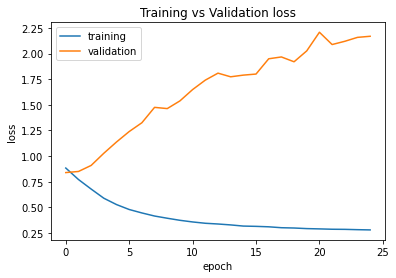

In [104]:
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'],loc='best')
plt.title("Training vs Validation loss")

Text(0.5, 1.0, 'Training vs Validation Accuracy')

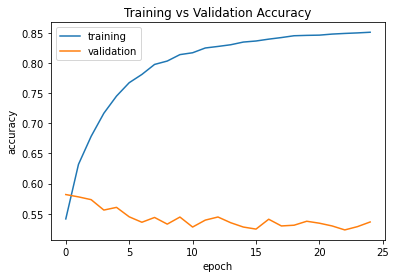

In [107]:
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training','validation'],loc='best')
plt.title("Training vs Validation Accuracy")

#### It can be seen that the model has overfit. Proceeding to the next section to understand and surmount this issue.